In [32]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [33]:
global_rng = np.random.default_rng(42)

In [34]:
def construct_cov_mtx(var_x: float, var_y: float, rho: float) -> np.ndarray:
	cov_xy = rho * np.sqrt(var_x * var_y)
	return np.array([[var_x, cov_xy],
					 [cov_xy, var_y]])


def simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points, rng=global_rng):
	if rng is None:
		rng = np.random.default_rng()
	cov = construct_cov_mtx(var_x, var_y, rho)
	data = rng.multivariate_normal([mu_x, mu_y], cov, size=n_points)
	x, y = data[:, 0], data[:, 1]
	return x, y

def add_gaussian_noise(x, y, noise_var, m=0, rng=global_rng):
	if rng is None:
		rng = np.random.default_rng()
	sd = np.sqrt(noise_var * m)
	x_noisy = x + rng.normal(0, sd, size=x.shape)
	y_noisy = y + rng.normal(0, sd, size=y.shape)
	return x_noisy, y_noisy



In [35]:
def tls_regression(x_vals, y_vals):
	"""Compute Total Least Squares (orthogonal) regression slope and intercept."""
	x_mean, y_mean = x_vals.mean(), y_vals.mean()
	Sxx = np.sum((x_vals - x_mean)**2)
	Syy = np.sum((y_vals - y_mean)**2)
	Sxy = np.sum((x_vals - x_mean)*(y_vals - y_mean))
	# TLS slope formula
	slope = (Syy - Sxx + np.sqrt((Sxx - Syy)**2 + 4*Sxy**2)) / (2*Sxy)
	intercept = y_mean - slope * x_mean
	return slope, intercept

In [36]:
def plot_scatter_with_tls(
	x, y,
	rho=None,                      # for annotation
	ax=None,
	xlim=(-0.3, 0.9),
	ylim=(2, 4),
	xtick_step=0.3,
	ytick_step=0.5,
	xlabel='Variable X',
	ylabel='Variable Y',
	point_size=90,
	alpha=0.6,
	line_n=200,
	line_label='TLS fit',
	annotate=True,
):
	if ax is None:
		fig, ax = plt.subplots(figsize=(6, 6))

	slope, intercept = tls_regression(x, y)
	r_value, _ = pearsonr(x, y)

	ax.scatter(x, y, s=point_size, alpha=alpha)

	# Draw fitted line over the visible x-range
	x_line = np.linspace(xlim[0], xlim[1], line_n)
	ax.plot(x_line, slope * x_line + intercept, linewidth=2, label=line_label)

	if annotate:
		if rho is not None:
			ax.text(0.05, 0.97, rf'$\rho = {rho}$',
					transform=ax.transAxes, va='top', fontsize=22, color='black')
		ax.text(0.05, 0.89, rf'$r = {r_value:.2f}$',
				transform=ax.transAxes, va='top', fontsize=22, color='red')

	ax.set_xlim(*xlim)
	ax.set_ylim(*ylim)
	ax.set_xlabel(xlabel, fontsize=22)
	ax.set_ylabel(ylabel, fontsize=22)

	ax.set_xticks(np.arange(xlim[0], xlim[1] + 1e-9, xtick_step))
	ax.set_yticks(np.arange(ylim[0], ylim[1] + 1e-9, ytick_step))
	ax.tick_params(axis='both', which='major', labelsize=22)

	return ax


In [37]:
def bootstrap_r(x, y, n_boot=500, ci=(16, 84), rng=None):
	"""
	Bootstrap CI for Pearson r by resampling points (paired x,y indices).

	x, y: 1D arrays of length n_points
	ci: tuple of percentiles, e.g. (2.5, 97.5) or (16, 84)
	"""
	if rng is None:
		rng = np.random.default_rng()

	x = np.asarray(x)
	y = np.asarray(y)
	if x.ndim != 1 or y.ndim != 1:
		raise ValueError("bootstrap_r expects 1D x and y arrays")
	if x.shape[0] != y.shape[0]:
		raise ValueError("x and y must have the same length")

	n = x.shape[0]
	r_boot = np.empty(n_boot, dtype=float)

	for b in range(n_boot):
		idx = rng.integers(0, n, size=n)  # resample indices with replacement
		r_boot[b], _ = pearsonr(x[idx], y[idx])

	low, high = np.percentile(r_boot, ci)
	return low, high


In [38]:
# def simulate_r_over_sweep(
# 	x_values,
# 	simulate_fn,          # function taking (rng) and returning (x, y)
# 	measure_fn,           # function taking (x, y, sweep_value, rng) and returning (x_meas, y_meas)
# 	n_traces=3,
# 	rng=global_rng
# ):
# 	if rng is None:
# 		rng = np.random.default_rng()

# 	x_values = np.asarray(x_values)
# 	results = np.empty((n_traces, x_values.size), dtype=float)
# 	ci_low  = np.empty_like(results)
# 	ci_high = np.empty_like(results)


# 	for t in range(n_traces):
# 		for idx, val in enumerate(x_values):
# 			x, y = simulate_fn(val, rng)                 # “true” data
# 			x_noisy, y_noisy = measure_fn(x, y, val, rng)        # add noise
# 			r, _ = pearsonr(x_noisy, y_noisy)
# 			results[t, idx] = r
# 			# low, high = bootstrap_r(x, y, n_boot=500, rng=global_rng)
# 			# ci_low[t, idx]  = low
# 			# ci_high[t, idx] = high

# 	return results, ci_low, ci_high
def simulate_r_over_sweep(
	x_values,
	simulate_fn,          # function: (val, rng) -> (x, y)
	measure_fn,           # function: (x, y, val, rng) -> (x_meas, y_meas)
	n_traces=3,
	rng=global_rng,
	do_bootstrap=True,
	n_boot=500,
	ci=(2.5, 97.5),
):
	if rng is None:
		rng = np.random.default_rng()

	x_values = np.asarray(x_values)
	results = np.empty((n_traces, x_values.size), dtype=float)

	# If bootstrap is off, return None for CI arrays to avoid confusion
	ci_low  = np.empty_like(results) if do_bootstrap else None
	ci_high = np.empty_like(results) if do_bootstrap else None

	for t in range(n_traces):
		for idx, val in enumerate(x_values):
			# 1) simulate "true" data for this sweep value
			x, y = simulate_fn(val, rng)

			# 2) apply measurement / noise model
			x_meas, y_meas = measure_fn(x, y, val, rng)

			# 3) compute r for this trace & x-value
			r, _ = pearsonr(x_meas, y_meas)
			results[t, idx] = r

			# 4) bootstrap CI for r (across points)
			if do_bootstrap:
				low, high = bootstrap_r(x_meas, y_meas, n_boot=n_boot, ci=ci, rng=rng)
				ci_low[t, idx] = low
				ci_high[t, idx] = high

	return results, ci_low, ci_high


In [39]:
def plot_traces(
	x_values,
	results,
	ci_low,
	ci_high,
	rho,
	xlabel,
	ylabel="Pearson's r",
	true_r=0.6,
	xscale='log',
	figsize=(16, 3),
	yticks=(0, 0.6, 1),
	ylim=(-0.4, 1.1),
	xlim=None,
	ticksize=22
):
	plt.figure(figsize=figsize)

	for t in range(results.shape[0]):
		plt.plot(x_values, results[t])
		plt.fill_between(
			x_values,
			ci_low[t],
			ci_high[t],
			alpha=0.2
		)

	plt.axhline(true_r, color='black', ls='--', label='True R')
	plt.xlabel(xlabel, size=ticksize)
	plt.ylabel(ylabel, size=ticksize)

	plt.xticks(size=ticksize)
	plt.yticks(list(yticks), size=ticksize)

	if xscale is not None:
		plt.xscale(xscale)

	if xlim is not None:
		plt.xlim(*xlim)

	plt.ylim(*ylim)

	ax = plt.gca()
	ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
	ax.tick_params(axis='x', labelsize=ticksize)

	plt.text(0.02, 0.97, rf'$\rho = {rho}$',
			 transform=ax.transAxes, va='top', fontsize=ticksize, color='black')

	plt.tight_layout()
	plt.show()


In [40]:
def average_repeats(x, y, n_repeats, noise_var, m=1.0, rng=None):
	if rng is None:
		rng = np.random.default_rng()

	n_points = x.shape[0]
	x_rep = np.empty((n_repeats, n_points))
	y_rep = np.empty((n_repeats, n_points))

	for i in range(n_repeats):
		x_rep[i], y_rep[i] = add_gaussian_noise(x, y, noise_var=noise_var, m=m, rng=rng)

	return x_rep.mean(axis=0), y_rep.mean(axis=0)


## SAMPLING

In [41]:
mu_x = 0.25
mu_y = 2.9
var_x = 0.025
var_y = 0.06
rho = 0.6

<Axes: xlabel='Variable X', ylabel='Variable Y'>

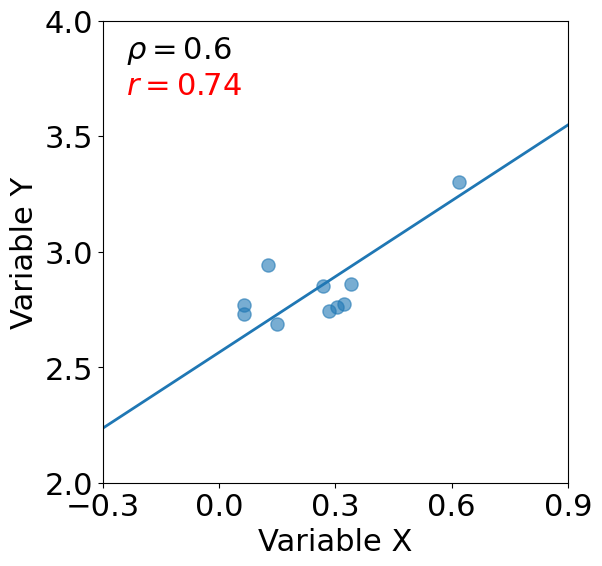

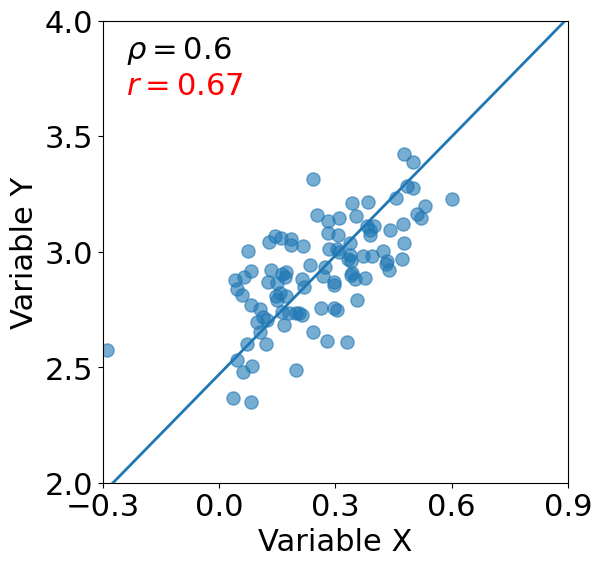

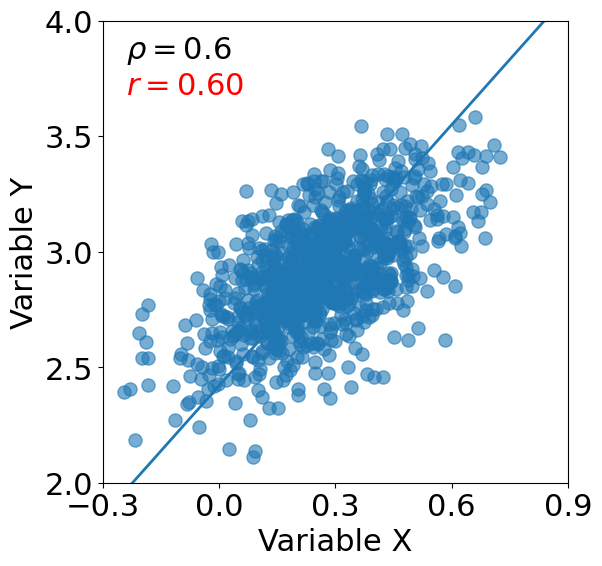

In [42]:
# 10 points
x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=10)
plot_scatter_with_tls(x, y, rho=rho)

# 100 points
x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=100)
plot_scatter_with_tls(x, y, rho=rho)

# 1000 points
x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=1000)
plot_scatter_with_tls(x, y, rho=rho)

<Axes: xlabel='Variable X', ylabel='Variable Y'>

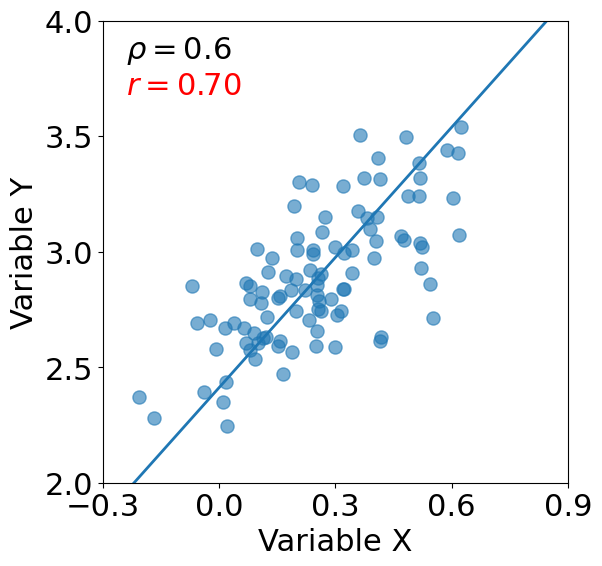

In [43]:
# 100 points
x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=100)
plot_scatter_with_tls(x, y, rho=rho)

<Axes: xlabel='Variable X', ylabel='Variable Y'>

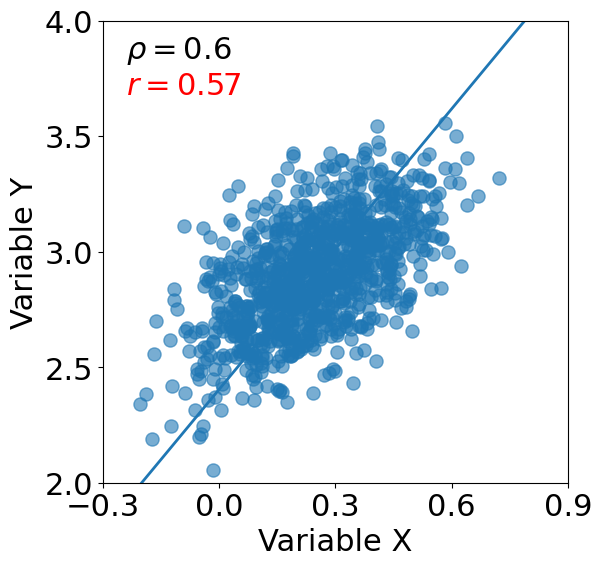

In [44]:
# 1000 points
x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=1000)
plot_scatter_with_tls(x, y, rho=rho)

In [45]:
def simulate_fn(N, rng):
	# first, simulate "true" (noise-free) data
	return simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=int(N), rng=rng)

def measure_true(x, y, N, rng):
	# for the "true" measurement, just return the original data
	return x, y

def measure_noisy(x, y, N, rng):
	# add Gaussian noise to both x and y
	return add_gaussian_noise(x, y, noise_var=0.06, m=1.0, rng=rng)

sample_sizes=np.logspace(1, 3, num=100).round().astype(int)
results_true, ci_low, ci_high = simulate_r_over_sweep(sample_sizes, simulate_fn, measure_true)
plot_traces(sample_sizes, results_true, ci_low, ci_high, rho=rho, xlabel='Sample size (N)', ticksize=22)

results_noisy, ci_low, ci_high = simulate_r_over_sweep(sample_sizes, simulate_fn, measure_noisy)
plot_traces(sample_sizes, results_noisy, ci_low, ci_high, rho=rho, xlabel='Sample size (N)', ticksize=22)



KeyboardInterrupt: 

## NOISE

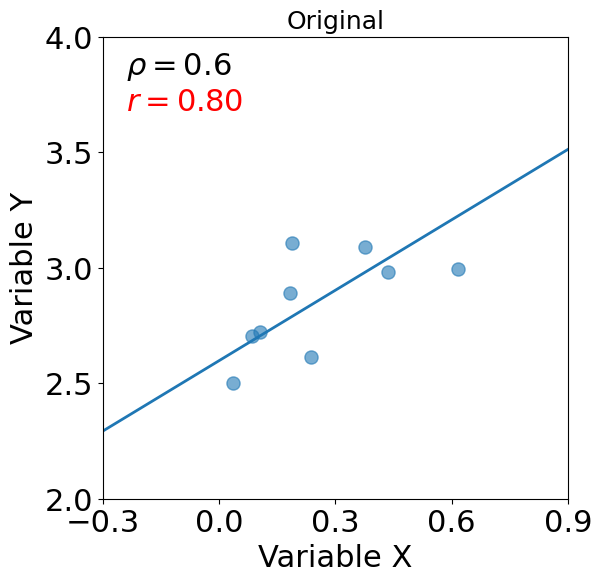

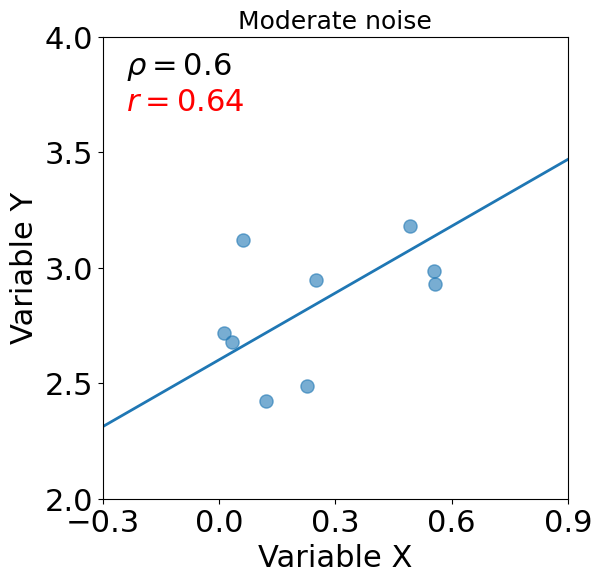

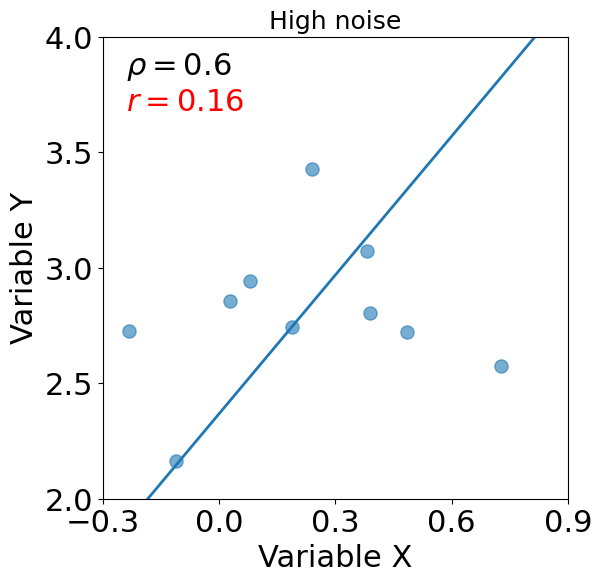

In [ ]:
# Parameters
var_x, var_y, noise_var = 0.06, 0.06, 0.06

# Base data once
x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=10, rng=global_rng)

# Plot: original + different noise multipliers
for m, title in [(0.0, 'Original'), (0.1, 'Moderate noise'), (1.0, 'High noise')]:
	if m == 0.0:
		x_plot, y_plot = x, y
	else:
		x_plot, y_plot = add_gaussian_noise(x, y, noise_var, m=m, rng=global_rng)

	ax = plot_scatter_with_tls(x_plot, y_plot, rho=rho)
	ax.set_title(title, fontsize=18)
	plt.show()

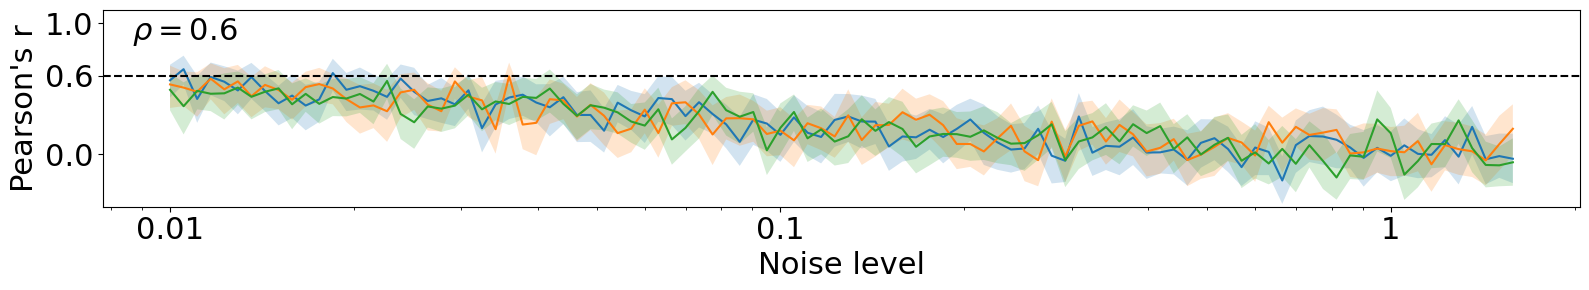

In [ ]:
noise_levels = np.logspace(-2, 0.2, num=100)
def simulate_fn(noise_level, rng):
	return simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=100, rng=rng)

def measure_fn(x, y, noise_level, rng):
	return add_gaussian_noise(x, y, noise_var=float(noise_level), m=1.0, rng=rng)

results, ci_low, ci_high = simulate_r_over_sweep(noise_levels, simulate_fn, measure_fn)
plot_traces(noise_levels, results, ci_low, ci_high, rho=rho, xlabel='Noise level', xscale='log', ticksize=22)


# MEANS

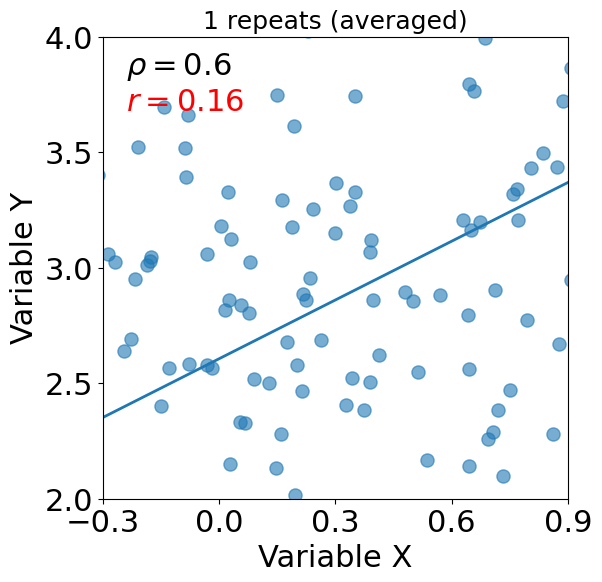

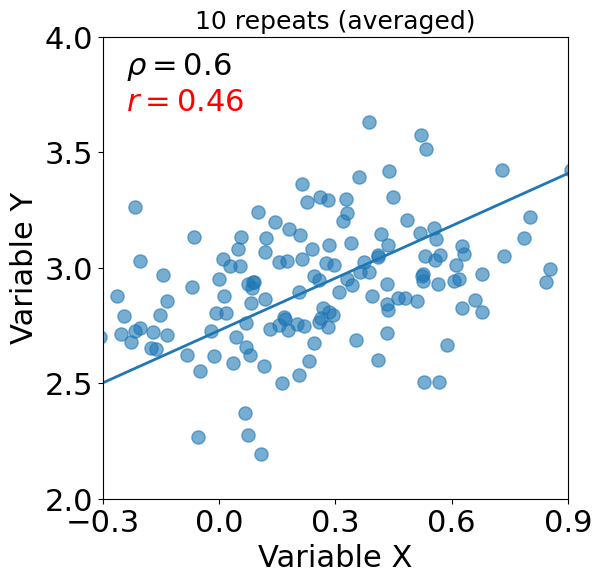

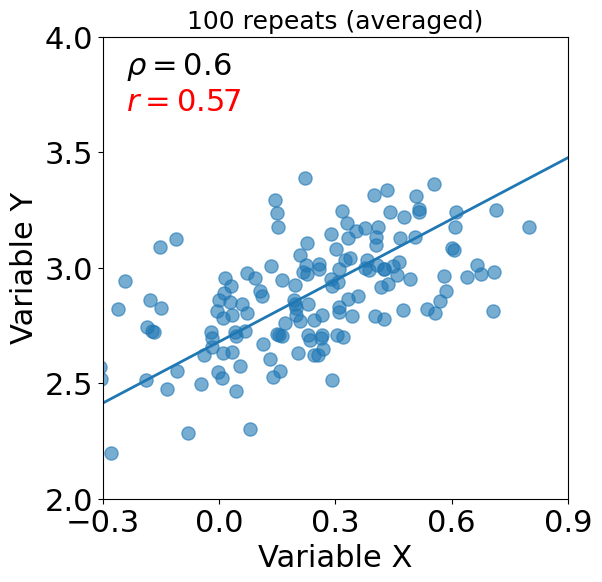

In [ ]:
# Parameters
var_x, var_y, noise_var = 0.06, 0.06, 0.3
n_points = 150
m = 1.0

# Base data once
x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=n_points, rng=global_rng)

# Plot: averaged over different numbers of repeats
for n_repeats in [1, 10, 100]:
	x_mean, y_mean = average_repeats(x, y, n_repeats=n_repeats, noise_var=noise_var, m=m, rng=global_rng)

	ax = plot_scatter_with_tls(x_mean, y_mean, rho=rho)
	ax.set_title(f'{n_repeats} repeats (averaged)', fontsize=18)
	plt.show()

In [ ]:
# # Parameters
# var_x, var_y, noise_var = 0.06, 0.06, 0.06
# n_points = 10
# m = 1.0
# rho = 0.6
# # Sweep repeats: 1..100 (log spaced looks nicer; use np.arange(1,101) if you want linear)
# repeat_counts = np.unique(np.logspace(0, 2, num=100).round().astype(int)) 

# def simulate_fn(R, rng):
#     # underlying true data (same N every time; new draw per trace per R)
#     x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=n_points, rng=rng)
#     return x, y

# def measure_noisy_avg(x, y, R, rng):
#     # average R noisy measurements of the same underlying x,y
#     x_mean, y_mean = average_repeats(x, y, n_repeats=int(R), noise_var=noise_var, m=m, rng=rng)
#     return x_mean, y_mean

# results = simulate_r_over_sweep(
#     repeat_counts,
#     simulate_fn=simulate_fn,
#     measure_fn=measure_noisy_avg,
#     n_traces=3,
#     rng=global_rng
# )

# plot_traces(
#     repeat_counts,
#     results,
#     rho=rho,
#     xlabel='Number of repeats (R)',
#     xscale='log',       # optional; helps when R spans 1..100
#     ticksize=22
# )


TypeError: plot_traces() missing 2 required positional arguments: 'ci_low' and 'ci_high'

In [47]:
def compute_noise_ceiling_splitHalf(measurements):
	"""
	Reference: Diedrichsen
	Computes the noise ceiling for a set of repeated measurements.
	Uses split-half reliability across multiple measurements and the geometric mean formula.
	"""
	even = measurements[0::2].mean(axis=0)   # repeats 0,2,4,...
	odd  = measurements[1::2].mean(axis=0)   # repeats 1,3,5,...
	r_i, _ = pearsonr(even, odd)
	# Spearman–Brown for 2 halves
	return (2 * r_i) / (1 + r_i)
	return r_m

def noise_ceiling_xy(x_reps, y_reps):
	rel_x = compute_noise_ceiling_splitHalf(x_reps)
	rel_y = compute_noise_ceiling_splitHalf(y_reps)
	return np.sqrt(rel_x * rel_y)

def bootstrap_r(xs, ys, n_boot=1000, ci=(16, 84), rng=None):
	if rng is None:
		rng = np.random.default_rng()

	n_points = xs.shape[1]
	r_boot = np.empty(n_boot)

	x_mean = xs.mean(axis=0)
	y_mean = ys.mean(axis=0)

	for b in range(n_boot):
		idx = rng.integers(0, n_points, n_points)
		r_boot[b], _ = pearsonr(x_mean[idx], y_mean[idx])

	return np.percentile(r_boot, ci)

def plot_r_curves(
	xvals,
	curves,
	labels,
	styles,
	title=None,
	true_r=0.6,
	xscale='log',
	ylim=(-0.2, 1.2),
	yticks=(0, 0.6, 1),
	xlabel='Number of thresholds',
	ylabel="Pearson's r",
	ticksize=22,
	bands=None,          # NEW: list same length as curves; each element is None or (low, high)
	band_alpha=0.2,      # NEW: transparency of CI band
	band_kwargs=None     # NEW: extra kwargs for fill_between
):
	"""
	bands: list of length len(curves). Each element can be:
	  - None (no band)
	  - (low, high) where low/high are arrays same length as xvals
	"""
	if band_kwargs is None:
		band_kwargs = {}

	xvals = np.asarray(xvals)

	fig, ax = plt.subplots(figsize=(16, 3))

	# Ensure bands is a list of proper length (or None)
	if bands is None:
		bands = [None] * len(curves)
	elif len(bands) != len(curves):
		raise ValueError("bands must be None or a list with the same length as curves")

	for y, lab, st, band in zip(curves, labels, styles, bands):
		y = np.asarray(y)

		# Plot the line first (so we can reuse its color for the band)
		line, = ax.plot(xvals, y, label=lab if lab else None, **st)

		# Plot CI band if provided
		if band is not None:
			low, high = band
			low = np.asarray(low)
			high = np.asarray(high)

			# Default: band color matches the line color unless overridden
			ax.fill_between(
				xvals, low, high,
				color=band_kwargs.get("color", line.get_color()),
				alpha=band_kwargs.get("alpha", band_alpha),
				linewidth=band_kwargs.get("linewidth", 0),
				zorder=band_kwargs.get("zorder", line.get_zorder() - 1),
			)

	# Reference line at the true correlation
	ax.axhline(true_r, color='k', linestyle='--')
	ax.text(0.02, 0.97, rf'$\rho = {true_r}$',
			transform=ax.transAxes, va='top', fontsize=22, color='black')


	# Axes formatting
	if xscale is not None:
		ax.set_xscale(xscale)
		ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

	ax.set_ylim(*ylim)
	ax.set_yticks(list(yticks))
	ax.set_xlabel(xlabel, fontsize=ticksize)
	ax.set_ylabel(ylabel, fontsize=ticksize)
	ax.tick_params(labelsize=ticksize)

	if title is not None:
		ax.set_title(title, fontsize=ticksize)

	# Legend: only shows entries where label is not None/empty
	handles, labs = ax.get_legend_handles_labels()
	if len(labs) > 0:
		ax.legend(loc='lower right', fontsize=ticksize-2, frameon=False)

	plt.tight_layout()
	plt.show()

	return ax

# def plot_r_curves(xvals, curves, labels, styles, title=None, true_r=0.6):
# 	fig, ax = plt.subplots(figsize=(16, 3))

# 	for y, lab, st in zip(curves, labels, styles):
# 		ax.plot(xvals, y, **st, label=lab)
		

# 	ax.axhline(true_r, color='k', linestyle='--')
# 	ax.set_xscale('log')
# 	ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
# 	ax.set_ylim(-0.2, 1.2)
# 	ax.set_yticks([0, true_r, 1])

# 	ax.set_xlabel('Number of thresholds', fontsize=22)
# 	ax.set_ylabel("Pearson's r", fontsize=22)
# 	ax.tick_params(labelsize=22)

# 	plt.text(0.02, 0.97, rf'$\rho = {true_r}$',
# 			transform=ax.transAxes, va='top', fontsize=22, color='black')


# 	if title is not None:
# 		ax.set_title(title, fontsize=22)

# 	if any(labels):
# 		ax.legend(loc='lower right', fontsize=16, frameon=False)

# 	plt.tight_layout()
# 	plt.show()


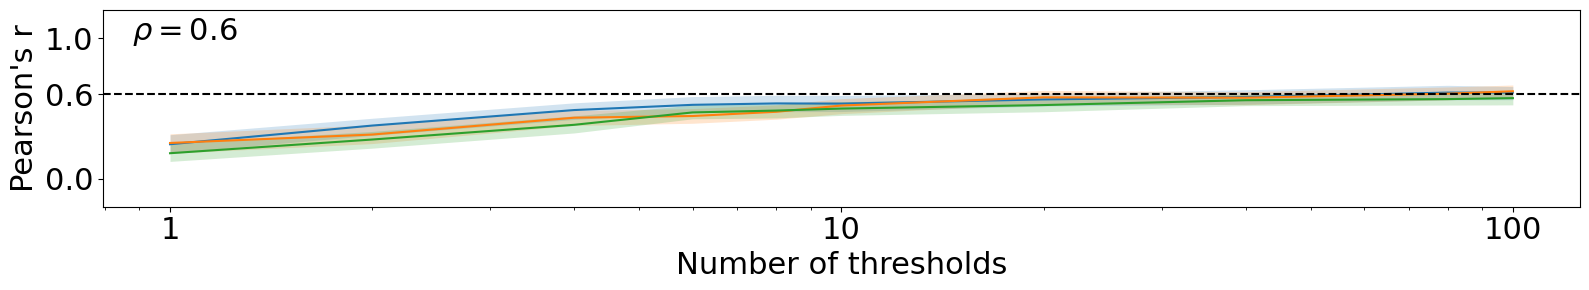

<Axes: xlabel='Number of thresholds', ylabel="Pearson's r">

In [48]:
# --- parameters ---
mu_x, mu_y = 0.25, 2.9
var_x, var_y, noise_var = 0.06, 0.06, 0.1
rho = 0.6

# x values
num_thresholds = np.array([1,2,4,6,8,10,20,40,80,100])

n_traces = 3
max_T = int(num_thresholds.max())
n_points = 200

# empty arrays to hold results
results_raw = np.empty((n_traces, num_thresholds.size))
results_unbiased = np.empty((n_traces, num_thresholds.size))
ci_low  = np.empty_like(results_raw)
ci_high = np.empty_like(results_raw)

for t in range(n_traces):
	# underlying true x,y once per trace
	x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=n_points, rng=global_rng) 
	
	# preallocate all repeats
	x_reps = np.empty((max_T, n_points))
	y_reps = np.empty((max_T, n_points))

	# generate all repeats
	for k in range(max_T):
		x_reps[k], y_reps[k] = add_gaussian_noise(x, y, noise_var=noise_var, m=m, rng=global_rng)

	# now sweep by taking first thresh repeats
	for idx, thresh in enumerate(num_thresholds):
		xs = x_reps[:thresh]
		ys = y_reps[:thresh]

		raw_r, _ = pearsonr(xs.mean(axis=0), ys.mean(axis=0))
		# nc = noise_ceiling_xy(xs, ys)

		results_raw[t, idx] = raw_r
		# results_unbiased[t, idx] = raw_r / nc

		low, high = bootstrap_r(xs, ys, n_boot=500, rng=global_rng)
		ci_low[t, idx]  = low
		ci_high[t, idx] = high



		

# --- plotting ---
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# # combined plot (raw + unbiased per trace)
# curves, labels, styles = [], [], []
# for t in range(n_traces):
# 	c = colors[t % len(colors)]
# 	curves.append(results_raw[t])
# 	labels.append('Raw' if t == 0 else None)
# 	styles.append(dict(linestyle='--', color=c, alpha=0.5))

# 	curves.append(results_unbiased[t])
# 	labels.append('Unbiased' if t == 0 else None)
# 	styles.append(dict(linestyle='-', color=c, alpha=1.0))

# plot_r_curves(num_thresholds, curves, labels, styles, title='Raw vs Unbiased', true_r=rho)

# raw-only
# plot_r_curves(
# 	num_thresholds,
# 	[results_raw[t] for t in range(n_traces)],
# 	labels=[None]*n_traces,
# 	styles=[dict(linestyle='-', color=colors[t % len(colors)], alpha=1.0) for t in range(n_traces)],
# 	# title='Raw only',
# 	true_r=rho
# )
curves = [results_raw[t] for t in range(n_traces)]
labels = [None]*n_traces
styles = [dict(linestyle='-', color=colors[t % len(colors)], alpha=1.0) for t in range(n_traces)]
bands  = [(ci_low[t], ci_high[t]) for t in range(n_traces)]

plot_r_curves(num_thresholds, curves, labels, styles, bands=bands, true_r=rho)


# # unbiased-only
# plot_r_curves(
# 	num_thresholds,
# 	[results_unbiased[t] for t in range(n_traces)],
# 	labels=[None]*n_traces,
# 	styles=[dict(linestyle='-', color=colors[t % len(colors)], alpha=1.0) for t in range(n_traces)],
# 	title='Unbiased only',
# 	true_r=rho
# )
